# 1. Configuration

In [1]:
import os
import gc
import cv2
import random
import numpy as np
import pandas as pd
from pathlib import Path
import typing as tp
from io import BytesIO
from PIL import Image
import h5py
import timm
from time import time
from tqdm.notebook import tqdm
import shutil

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

import torch
import torchvision
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.cuda import amp
from torch.utils.data import Dataset
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
class CFG:
    is_kaggle = False
    if not is_kaggle:
        OUTPUT_DIR = Path('/root/Development/Kaggle/ISIC2024/models')
        TRAIN_DIR = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-image/image')
        TRAIN_HDF5 = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-image.hdf5')
        TEST_HDF5 = Path('/root/Development/Kaggle/ISIC2024/data/raw/test-image.hdf5')
        TRAIN_META = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-metadata.csv')
        TEST_META = Path('/root/Development/Kaggle/ISIC2024/data/raw/test-metadata.csv')
        SAMPLE_SUB = Path('/root/Development/Kaggle/ISIC2024/data/raw/sample_submission.csv')
    else:
        OUTPUT_DIR = Path('/kaggle/input/isic2024-baseline')
        TRAIN_DIR = Path('/kaggle/input/isic-2024-challenge/train-image/image')
        TRAIN_HDF5 = Path('/kaggle/input/isic-2024-challenge/train-image.hdf5')
        TEST_HDF5 = Path('/kaggle/input/isic-2024-challenge/test-image.hdf5')
        TRAIN_META = Path('/kaggle/input/isic-2024-challenge/train-metadata.csv')
        TEST_META = Path('/kaggle/input/isic-2024-challenge/test-metadata.csv')
        SAMPLE_SUB = Path('/kaggle/input/isic-2024-challenge/sample_submission.csv')
    max_epoch = 2
    n_folds = 2
    n_classes = 2
    random_seed = 42
    deterministic = True
    enable_amp = True
    view = True
    
    # model_name = "efficientnet_b0.ra_in1k"
    model_name = "resnet18.a1_in1k"
    pretrained = False
    img_size = 224
    interpolation = cv2.INTER_AREA
    es_patience = 5 
    batch_size = 32
    lr = 1.0e-03
    weight_decay = 1.0e-02 # default
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"

In [3]:
train_meta = pd.read_csv(CFG.TRAIN_META)
test_meta = pd.read_csv(CFG.TEST_META)

# head
display(train_meta[train_meta['target'] > 0.5].head(10))
display(train_meta.head())
display(test_meta.head())

/tmp/ipykernel_85062/3628074767.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_meta = pd.read_csv(CFG.TRAIN_META)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
387,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,13.054772,19.090458,21.211776,26.302386,24.907158,46.536028,58.389811,23.395088,34.784341,40.964534,25.940259,3.287692,5.038595,-2.121318,-11.389253,11.836020,12.342322,0.763841,Torso Front Top Half,Torso Front,6.677133,1.597228e-02,5.936484,9.830578,32.598015,3.514434,5.464301,2.717044,0.472358,0,61.956005,1180.003540,-77.904053,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
935,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,21.394010,25.553420,24.914770,36.588750,32.839750,44.298420,49.347720,49.373060,57.114240,6.192531,30.648580,0.624458,4.793001,0.638651,-7.741185,8.023705,5.716512,0.672715,Head & Neck,Head & Neck,2.710643,9.713997e-04,7.567831,1.757932,13.776510,0.549971,1.604156,2.798056,0.576744,15,54.423520,1675.860000,-37.749880,Memorial Sloan Kettering Cancer Center,CC-BY,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
1245,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,24.249430,26.160100,25.295430,42.488470,35.041320,38.002700,46.209460,50.728930,58.546240,12.103580,38.025960,1.401430,9.230707,0.864665,-7.817310,8.023790,5.621653,0.907116,Torso Front Top Half,Torso Front,3.481341,1.629116e-12,8.688260,4.108186,21.453450,1.340916,1.539307,3.697858,0.546485,155,84.834820,1441.758000,-60.321040,Memorial Sloan Kettering Cancer Center,CC-BY,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
1846,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,20.194650,26.805590,28.459890,37.254570,34.896840,46.015270,54.641140,56.674930,64.638890,13.267030,30.444160,1.472167,5.677403,-1.654301,-7.963960,8.284219,5.481429,0.745061,Right Arm - Upper,Right Arm,3.573096,1.106073e+00,6.435350,3.850777,20.097350,1.104453,2.575811,2.600541,0.428889,160,293.127500,1425.201000,50.789730,Memorial Sloan Kettering Cancer Center,CC-BY,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
3478,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,22.008635,24.066940,26.734379,39.219278,34.628125,37.853948,50.537646,55.210012,66.135030,15.049728,24.313243,2.243673,8.958027,-2.667440,-10.925018,11.522597,7.399501,0.690814,Torso Back Top Third,Torso Back,4.222128,2.115099e-02,5.267599,7.734870,19.128714,2.904396,4.122797,3.134399,0.422091,65,-128.599152,1481.198364,13.294312,Memorial Sloan Kettering Cancer Center,CC-BY,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Bas

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,28.38412,27.043640,36.410100,33.640000,51.220960,53.505430,24.97985,31.114600,3.846876,22.907010,0.461149,2.797056,1.340481,-6.134747,6.436557,6.843057,0.664465,Torso Back Top Third,Torso Back,2.187644,1.698104e-02,5.435366,1.143374,9.387248,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,31.31752,27.524318,35.467806,29.169579,62.004494,70.664619,59.90409,68.141071,2.120473,18.957821,0.000000,6.990705,3.793202,-8.236981,9.151127,6.083388,0.926698,Left Leg - Upper,Left Leg,1.032666,2.107364e-01,4.322201,0.000000,6.340311,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,30.46368,28.384240,38.939500,34.686660,51.474730,54.915410,35.81945,41.358640,3.396510,19.464400,0.251236,4.316465,2.079433,-5.539191,6.041092,5.446997,0.894776,Torso Back Top Third,Torso Back,1.520786,8.052259e-13,3.968912,0.721739,8.130868,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


# 2. Preprocessing

# 3. Split to fold

In [4]:
def split_fold(df:pd.DataFrame):
    # if 'fold' in df.columns:
    #     return df
    
    df['fold'] = -1
    # object
    skf = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.random_seed)

    for i, (train_index, test_index) in enumerate(skf.split(df, df['target'], df['patient_id'])):
        df.loc[test_index, 'fold'] = i
    
    return df
        
train_meta = split_fold(train_meta)
display(train_meta.head().T)

# check
if CFG.view:
    print(train_meta.groupby('fold')['target'].value_counts().head(300))

,0,1,2,3,4
isic_id,ISIC_0015670,ISIC_0015845,ISIC_0015864,ISIC_0015902,ISIC_0024200
target,0,0,0,0,0
patient_id,IP_1235828,IP_8170065,IP_6724798,IP_4111386,IP_8313778
age_approx,60.0,60.0,60.0,65.0,55.0
sex,male,male,male,male,male
anatom_site_general,lower extremity,head/neck,posterior torso,anterior torso,anterior torso
clin_size_long_diam_mm,3.04,1.1,3.4,3.22,2.73
image_type,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up
tbp_tile_type,3D: white,3D: white,3D: XP,3D: XP,3D: white
tbp_lv_A,20.244422,31.71257,22.57583,14.242329,24.72552


fold  target
0     0         193425
      1            175
1     0         207241
      1            218
Name: count, dtype: int64


# 4. Dataset

In [5]:
# setting seed in each env
def set_random_seed(seed: int = 42, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

# function to set tensor to device
def to_device(
    tensors: tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor]],
    device: torch.device, *args, **kwargs
):
    if isinstance(tensors, tuple):
        return (t.to(device, *args, **kwargs) for t in tensors)
    elif isinstance(tensors, dict):
        return {
            k: t.to(device, *args, **kwargs) for k, t in tensors.items()}
    else:
        return tensors.to(device, *args, **kwargs)

In [6]:
def get_transforms():
    train_transform = A.Compose([
        A.Resize(p=1.0, height=CFG.img_size, width=CFG.img_size, interpolation = CFG.interpolation),
        ToTensorV2(p=1.0)
    ])
    val_transform = A.Compose([
        A.Resize(p=1.0, height=CFG.img_size, width=CFG.img_size, interpolation = CFG.interpolation),
        ToTensorV2(p=1.0)
    ])
    return train_transform, val_transform

class ISICDataset(Dataset):
    def __init__(self, 
                 df: pd.DataFrame,
                 fp_hdf: str|Path,
                 transform: A.Compose=None,
                 ):
        self.df = df
        if 'target' in self.df.columns:
            self.is_training = True
            self.targets = df['target'].values
        else:
            self.is_training = False
        self.fp_hdf = h5py.File(fp_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        image = np.array(Image.open(BytesIO(self.fp_hdf[isic_id][()])))
        if self.is_training:
            target = self.targets[index]
        else:
            target = None
        
        if self.transform:
            return (self._apply_transform(image), target)
        else:
            return (image, target)
    
    def _apply_transform(self, img:np.ndarray):
        """apply transform to image"""
        transformed = self.transform(image=img)
        img = transformed["image"]# .float()# .half()
        return img

# 5. Model

In [7]:
class timmModel(nn.Module):

    def __init__(
            self,
            model_name: str,
            pretrained: bool,
            in_channels: int,
            num_classes: int,
            is_training: bool=False
        ):
        super().__init__()
        self.model = timm.create_model(
            model_name=model_name, 
            pretrained=pretrained, 
            in_chans=in_channels,
            num_classes=num_classes,
            global_pool=''
        )
        self.output_type = ['infer', 'loss']
        self.is_training = is_training
        
        arch = 'resnet18'
        dim_dict = {
			'resnet18':512,
		}
        dim = dim_dict.get(arch, 1280)
        
        self.dropout = nn.ModuleList([
			nn.Dropout(0.5) for i in range(5)
		])
        self.target=nn.Linear(dim, 1)
        

    def forward(self, x, target=None):
        batch_size = len(x)
        
        x = self.model(x)    
        # print('resnet18 output: ', x.shape)
        pool = F.adaptive_avg_pool2d(x, 1)
        # print('after pooling: ', pool.shape)
        reshaped = pool.reshape(batch_size, -1)  
        # print('after reshape: ', reshaped.shape)
        
        if self.is_training:
            logit = 0
            # print(len(self.dropout))
            for i in range(len(self.dropout)):
                dropped = self.dropout[i](reshaped)
                # print(dropped.shape)
                logit += self.target(dropped)
            logit = logit / len(self.dropout)
        else:
            logit = self.target(reshaped)
            
        output = {}
        if 'loss' in self.output_type:
            if target.dim() == 1:
                target = target.view(-1, 1)
            output['bce_loss'] = F.binary_cross_entropy_with_logits(logit.float(), target.float())

        if 'infer' in self.output_type:
            output['target'] = torch.sigmoid(logit)

        return output

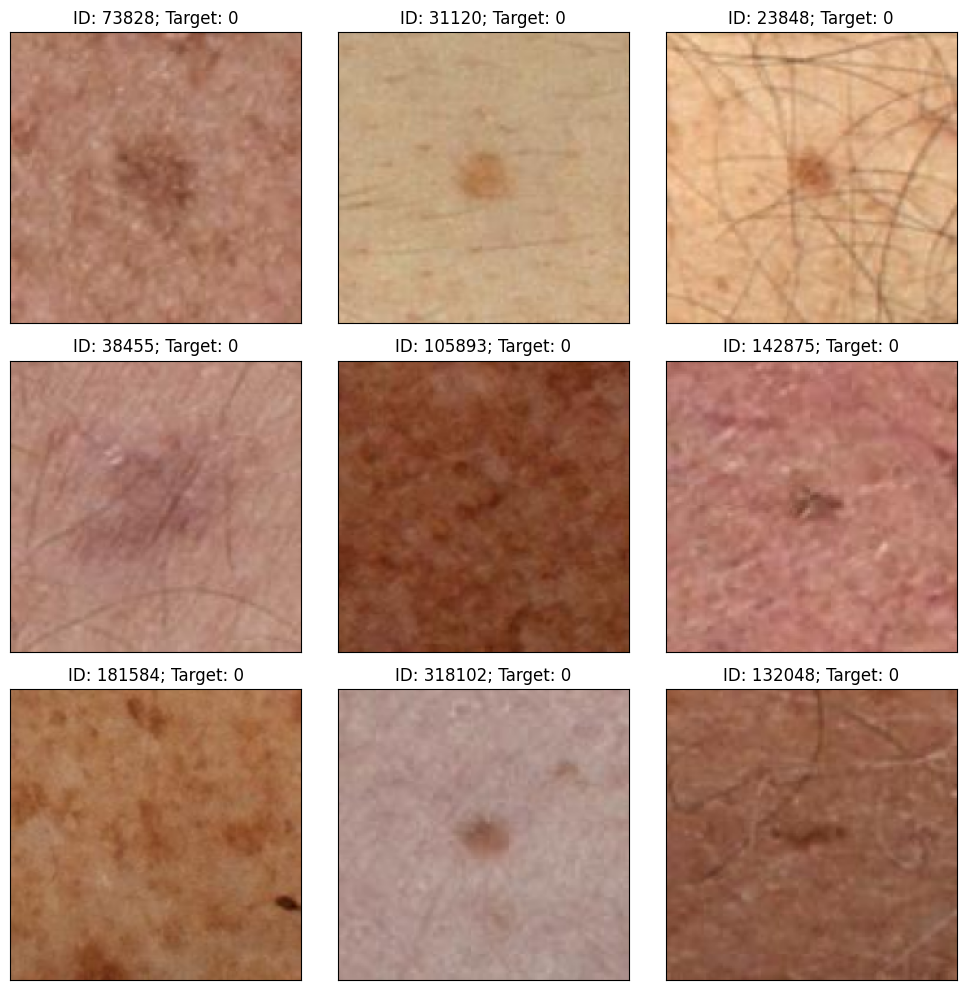

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

if CFG.view:
    def show_batch(ds, row=3, col=3):
        fig = plt.figure(figsize=(10, 10))
        img_index = np.random.randint(0, len(ds)-1, row*col)
        
        for i in range(len(img_index)):
            img, label = ds[img_index[i]]
            
            if isinstance(img, torch.Tensor):
                img = img.detach().numpy()
                # Check if the image is in (C, H, W) and transpose it to (H, W, C)
                if img.shape[0] == 3:  # Assuming the image is (C, H, W)
                    img = np.transpose(img, (1, 2, 0))
            
            ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
            ax.imshow(img)  # Remove cmap parameter for RGB images
            ax.set_title(f'ID: {img_index[i]}; Target: {label}')
        
        plt.tight_layout()
        plt.show()

    _train_transform, _ = get_transforms()
    _dataset = ISICDataset(df=train_meta, fp_hdf=CFG.TRAIN_HDF5, transform=_train_transform)
    show_batch(_dataset)


# 6. Training

In [9]:
# reference
def train_one_fold(val_fold: int, 
                   train: pd.DataFrame,
                   output_path: str|Path
                   ):
    """Main"""
    # If True, forces cuDNN to benchmark multiple convolution algorithms and choose the fastest one
    torch.backends.cudnn.benchmark = True
    set_random_seed(CFG.random_seed, deterministic=CFG.deterministic)
    # set device with pytorch env
    device = torch.device(CFG.device)
    
    train_transform, val_transform = get_transforms()
    
#     train_dataset = Bird2024Dataset(**train_path_label, transform=train_transform)
    train_dataset = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5, train_transform)
    val_dataset = ISICDataset(train[train['fold']==val_fold], CFG.TRAIN_HDF5, val_transform)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
    
    model = timmModel(
        model_name=CFG.model_name, 
        pretrained=CFG.pretrained, 
        num_classes=0, # no classification head
        in_channels=3, # RBG
        is_training=True
    )
    model.to(device)
    
    optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = lr_scheduler.OneCycleLR(
        optimizer=optimizer, epochs=CFG.max_epoch,
        pct_start=0.0, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, div_factor=25, final_div_factor=1e4
    )
    
#     loss_func = KLDivLossWithLogits()
    # loss_func = nn.CrossEntropyLoss()
    # loss_func = nn.BCEWithLogitsLoss()
#     loss_func = FocalLossBCE()
    # loss_func.to(device)
#     loss_func_val = KLDivLossWithLogitsForVal()
#     loss_func_val = nn.CrossEntropyLoss()
    # loss_func_val = nn.BCEWithLogitsLoss()
#     loss_func_val = FocalLossBCE()
    
    use_amp = CFG.enable_amp
    scaler = amp.GradScaler(enabled=use_amp)
    
    best_val_loss = 1.0e+09
    best_epoch = 0
    train_loss = 0
    val_loss = 0
    
    for epoch in range(1, CFG.max_epoch + 1):
        epoch_start = time()
        model.train()
        for batch in tqdm(train_loader):
            
            x, t = batch
            x = x.float()/255
#             print(x)
#             print(t)
            x = to_device(x, device)
            t = to_device(t, device)
                
            optimizer.zero_grad()
            with amp.autocast(use_amp):
                output = model(x, t)
                loss = output['bce_loss']
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            scheduler.step()
            
        train_loss /= len(train_loader)
            
        model.eval()
        for batch in tqdm(val_loader):
            x, t = batch
            x = x.float()/255
            x = to_device(x, device)
            t = to_device(t, device)
            with torch.no_grad(), amp.autocast(use_amp):
                output = model(x, t)
            loss = output['bce_loss']
            val_loss += loss.item()
        val_loss /= len(val_loader)
        
        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            # print("save model")
            torch.save(model.state_dict(), str(output_path / f'snapshot_epoch_{epoch}.pth'))
        
        elapsed_time = time() - epoch_start
        print(
            f"[epoch {epoch}] train loss: {train_loss: .6f}, val loss: {val_loss: .6f}, elapsed_time: {elapsed_time: .3f}")
        
        if epoch - best_epoch > CFG.es_patience:
            print("Early Stopping!")
            break
            
        train_loss = 0
        val_loss = 0
            
    return val_fold, best_epoch, best_val_loss

### Train  

In [10]:
score_list = []
for fold_id in range(CFG.n_folds):
    output_path = CFG.OUTPUT_DIR / f"fold{fold_id}"
    output_path.mkdir(exist_ok=True)
    print(f"[fold{fold_id}]")
    score_list.append(train_one_fold(fold_id, train_meta, output_path))

[fold0]


  0%|          | 0/6483 [00:00<?, ?it/s]

  0%|          | 0/6050 [00:00<?, ?it/s]

[epoch 1] train loss:  0.009060, val loss:  0.007073, elapsed_time:  136.125


  0%|          | 0/6483 [00:00<?, ?it/s]

  0%|          | 0/6050 [00:00<?, ?it/s]

[epoch 2] train loss:  0.007579, val loss:  0.006367, elapsed_time:  135.776
[fold1]


  0%|          | 0/6050 [00:00<?, ?it/s]

  0%|          | 0/6484 [00:00<?, ?it/s]

[epoch 1] train loss:  0.008117, val loss:  0.008014, elapsed_time:  131.913


  0%|          | 0/6050 [00:00<?, ?it/s]

  0%|          | 0/6484 [00:00<?, ?it/s]

[epoch 2] train loss:  0.006775, val loss:  0.007632, elapsed_time:  135.480


# 7. Validation

In [11]:
print(score_list)

[(0, 2, 0.006367027579752867), (1, 2, 0.00763177910849741)]


In [12]:
# select the best model and delete others
best_log_list = []
for (fold_id, best_epoch, _) in score_list:
    
    # select the best model
    exp_dir_path = CFG.OUTPUT_DIR / f"fold{fold_id}"
    best_model_path = exp_dir_path / f"snapshot_epoch_{best_epoch}.pth"
    # copy to new place
    copy_to = CFG.OUTPUT_DIR / f"./best_model_fold{fold_id}.pth"
    shutil.copy(best_model_path, copy_to)
    
    for p in exp_dir_path.glob("*.pth"):
        # delete
        p.unlink()

In [13]:
# Function for inference
def run_inference_loop(model, loader, device):
    model.to(device)
    model.eval()
    model.output_type = ['infer']
    pred_list = []
    with torch.no_grad():
        for batch in tqdm(loader):
            x = to_device(batch[0], device)
            x = x.float()/255
            output = model(x)
            y = output['target']
            pred_list.append(y.detach().cpu().numpy())
    
    # concatenate to vertical (to df like from long scroll like)
    pred_arr = np.concatenate(pred_list)
    del pred_list
    return pred_arr

### Prediction

In [14]:
# predict for train data with metrix(CV. not test data)

after_runned = True
if after_runned:

    # label_arr = train[CLASSES].values
    oof_pred_arr = np.zeros((len(train_meta), CFG.n_classes-1))
    score_list = []

    for fold_id in range(CFG.n_folds):
        print(f"\n[fold {fold_id}]")
        device = torch.device(CFG.device)

        # get_dataloader
        _, val_transform = get_transforms()
        val_dataset = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5, transform=val_transform)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)

        # # get model
        model_path = CFG.OUTPUT_DIR / f"best_model_fold{fold_id}.pth"
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=False, 
            in_channels=3,
            num_classes=0,
            is_training=False
        )
        model.load_state_dict(torch.load(model_path, map_location=device))

        # # inference
        val_pred = run_inference_loop(model, val_loader, device)
        val_idx = train_meta[train_meta["fold"] == fold_id].index.values
        oof_pred_arr[val_idx] = val_pred

        del val_idx
        del model, val_loader
        torch.cuda.empty_cache()
        gc.collect()


[fold 0]


  0%|          | 0/6050 [00:00<?, ?it/s]


[fold 1]


  0%|          | 0/6484 [00:00<?, ?it/s]

### Metrix

In [15]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc


In [16]:
# make true array
label_arr = train_meta['target']
# one-hot
# ture_arr = np.zeros((label_arr.size, CFG.n_classes))
# ture_arr[np.arange(label_arr.size), label_arr] = 1
ture_arr = pd.DataFrame(label_arr)

# oof
oof = pd.DataFrame(oof_pred_arr)

micro_roc_auc_ovr = comp_score(
    ture_arr,
    oof,
    ""
)

print(f"CV: Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.10f}")

CV: Micro-averaged One-vs-Rest ROC AUC score:
0.0773510648


In [17]:
display(oof.loc[0].sum())

0.0014093461213633418

In [18]:
display(oof.head())
display(ture_arr.head())
display(oof.tail())
display(ture_arr.tail())

,0
0,0.001409
1,0.012591
2,0.000339
3,0.000496
4,0.003087


,target
0,0
1,0
2,0
3,0
4,0


,0
401054,0.001075
401055,0.000339
401056,0.000438
401057,0.000369
401058,0.000691


,target
401054,0
401055,0
401056,0
401057,0
401058,0
